# Team 2: Hydrographic Properties
In this notebook, your team will create a visualization of the mean hydrographic properties in the MITgcm Southern Ocean Reentrant Channel Tutorial.

At the end of this exercise, you will share your code with your classmates and explain two key features we have yet to address in class:
1. Organizing subplots with the GridSpec module
2. Using the Polygon module to mask out bathymetric regions of ocean transects

Begin by reading in some pertinent Python packages:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm

# this module will help organize your subplots
from matplotlib.gridspec import GridSpec

# this module will be used to mask out bathymetry features
from matplotlib.patches import Polygon

## Organize Your Notebook
To begin, make a path to your model folder and re-define the dimensions of the grid from the previous notebook:

In [153]:
model_folder = '/Users/cool/Workspace/MLML/ms274_fall2025/Lecture/Week 7/model'

In [154]:
n_rows = 20
n_cols = 40
Nr = 49

In addition to the model rows and columns, we will also need the dimensions for x, y and z. Create these here using information from the `data` file:

In [159]:
# create arrays for x, y, and z
dx = 50e3
dy = 50e3
x = np.arange(n_cols) * dx
y = np.arange(n_rows) * dy
r =  [5.48716549,   6.19462098,   6.99291201,   7.89353689,
         8.90937723,  10.05483267,  11.34595414,  12.80056778,
        14.43837763,  16.28102917,  18.35210877,  20.67704362,
        23.28285446,  26.1976981 ,  29.45012046,  33.06792588,
        37.07656002,  41.496912  ,  46.34247864,  51.61592052,
        57.30518684,  63.37960847,  69.78661289,  76.44996107,
        83.27047568,  90.13003112,  96.89898027, 103.44631852,
       109.65099217, 115.4122275 , 120.65692923, 125.34295968,
       129.45821977, 133.01641219, 136.05088105, 138.60793752,
       140.74074276, 142.50436556, 143.95220912, 145.133724  ,
       146.09317287, 146.86917206, 147.49475454, 147.99774783,
       148.40131516, 148.72455653, 148.98310489, 149.18968055,
       149.35458582]
print(x/1000)
print(np.cumsum(r))
Z = np.cumsum(r)

[   0.   50.  100.  150.  200.  250.  300.  350.  400.  450.  500.  550.
  600.  650.  700.  750.  800.  850.  900.  950. 1000. 1050. 1100. 1150.
 1200. 1250. 1300. 1350. 1400. 1450. 1500. 1550. 1600. 1650. 1700. 1750.
 1800. 1850. 1900. 1950.]
[   5.48716549   11.68178647   18.67469848   26.56823537   35.4776126
   45.53244527   56.87839941   69.67896719   84.11734482  100.39837399
  118.75048276  139.42752638  162.71038084  188.90807894  218.3581994
  251.42612528  288.5026853   329.9995973   376.34207594  427.95799646
  485.2631833   548.64279177  618.42940466  694.87936573  778.14984141
  868.27987253  965.1788528  1068.62517132 1178.27616349 1293.68839099
 1414.34532022 1539.6882799  1669.14649967 1802.16291186 1938.21379291
 2076.82173043 2217.56247319 2360.06683875 2504.01904787 2649.15277187
 2795.24594474 2942.1151168  3089.60987134 3237.60761917 3386.00893433
 3534.73349086 3683.71659575 3832.9062763  3982.26086212]


Next, read in the bathymetry file just as we did in the previous notebook:

In [158]:
# read in the bathymetry file
bathy = np.fromfile(os.path.join(model_folder, 'input','bathy.50km.bin'),
                    dtype='>f4').reshape(n_cols, n_rows)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cool/Workspace/MLML/ms274_fall2025/Lecture/Week 7/model/input/bathy.50km.bin'

## Function to read in a 3D state conditions
Next, we'll make two helper functions that will help with the plotting routine. These scripts will bundle up some of the code so that the resulting plotting loop is not too long.

The first helper function is called `read_3D_conditions_from_file` and should read in a file for the 3D state outputs from the model. The function should take in a file path as an argument and return the surface fields for `Theta`, `Uvel`, and `Wvel` field for plotting. 

Implement your function here:

In [40]:
grid = np.fromfile(os.path.join(model_folder, 'Diags', 'state_monthly.0000933120.data'), '>f4').reshape((4, Nr, n_cols, n_rows))

In [55]:
# make a function to output the following 3D grids:
# Theta, Uvel, Wvel

def read_3D_conditions_from_file(file_path):
    grid = np.fromfile(file_path, '>f4').reshape((4, Nr, n_cols, n_rows))
     # fields(1:4,2) =   'THETA   ', 'VVEL    ', 'UVEL    ',
     #               'WVEL    ',
    theta = grid[0]
    vvel = grid[1]
    uvel = grid[2]
    wvel = grid[3]
    return theta, vvel, uvel, wvel 

path = os.path.join(model_folder, 'run', 'Diags', 'state_monthly.0000933120.data')
shaper, vvel, uvel, wvel  = read_3D_conditions_from_file(path)
np.size(theta)
np.shape(theta)

(49, 40, 20)

## Function to Average a Set of Files

The next helper function, called `average_3D_files`, should create an average 3D field for `Theta`, `Uvel`, and `Wvel` given a list of model iteration numbers. This function should loop through the list of number, read in the fields, and keep track of a running sum. Then, at the end of the loop, the function should compute and outpute the average of each field.

In [60]:
# design your averaging function here
# Time stepping parameters
 # &PARM03
 # nIter0=870912,
 # nTimeSteps=63072,
 # deltaT=1000.0,
 # pChkptFreq=31104000.0,
 # chkptFreq=15552000.0,
 # dumpFreq=0,
 # monitorFreq=864000.,
 # monitorSelect=2,
 # tauThetaClimRelax=864000.,
 # momDissip_In_AB=.FALSE.,
print(876096 - 873504)
initial_i = 873504
step_size = 2592
end_i = 933120
iteration_numbers = np.arange(initial_i, end_i+1, step_size)


def average_3D_files(iteration_numbers):
    avg_theta = np.zeros_like(shaper)
    avg_vvel = np.zeros_like(shaper)
    avg_uvel = np.zeros_like(shaper)
    avg_wvel = np.zeros_like(shaper)
    n = len(iteration_numbers)
    for i in iteration_numbers:
        path = os.path.join(model_folder, 'run', 'Diags', 'state_monthly.0000' + str(i) + '.data')
        theta, vvel, uvel, wvel  = read_3D_conditions_from_file(path)
        avg_theta += theta 
        avg_vvel += vvel
        avg_uvel += uvel 
        avg_wvel += wvel
    return avg_theta/n, avg_vvel/n, avg_uvel/n, avg_wvel/n

2592


## Make a Cross-Sectional Plot

Next, make a figure with 4 panels: a top-down bathymetry panel, and 3 panels showing a cross-section of `Theta`, `Uvel`, and `Wvel` across the channel. Output your figure as a png file.

In [61]:
# make a list of all iteration numbers corresponding to the 
# state_3D_daily files
initial_i = 873504
step_size = 2592
end_i = 933120
iteration_numbers = np.arange(initial_i, end_i+1, step_size)

In [92]:
# compute the average 3D field of the above files
Theta, Vvel, Uvel, Wvel = average_3D_files(iteration_numbers)

H = 4000.0   # total depth (m)
dz = H / Nr

# RC = cell center depths (negative values)
RC = - (np.arange(Nr) + 0.5) * dz
np.shape(Theta)
# np.shape(Theta[:,:, 20])

(49, 40, 20)

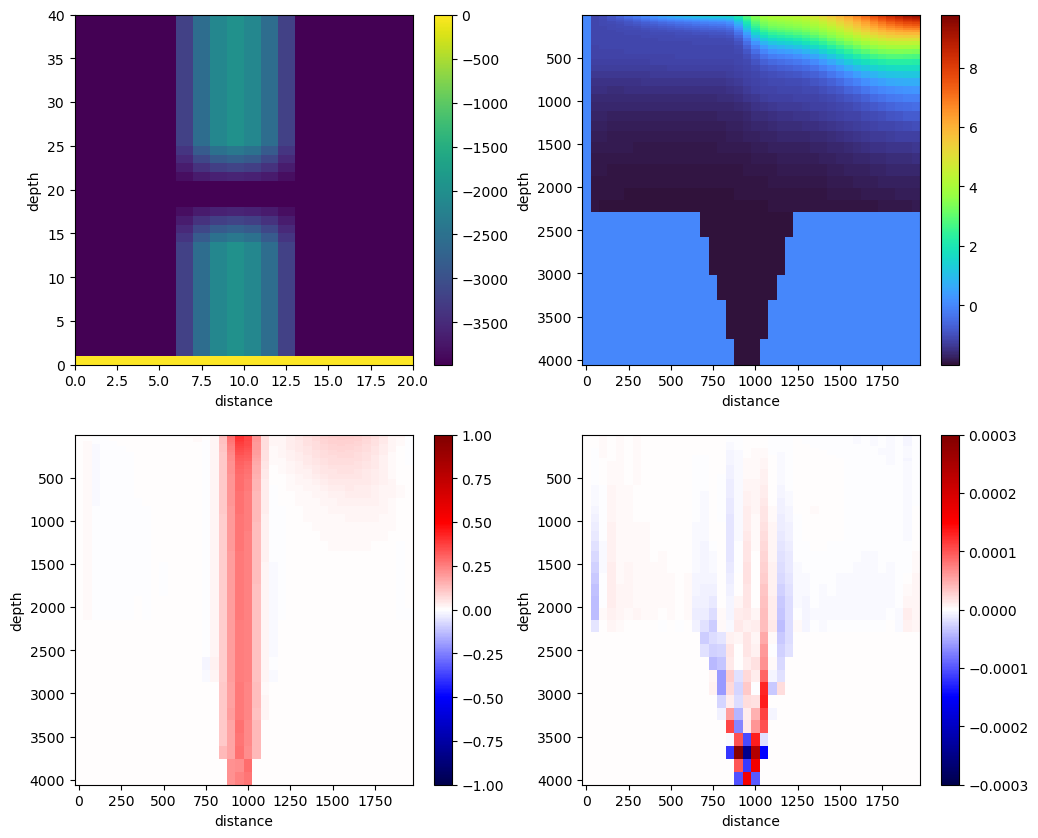

In [125]:
# make your figure here
fig = plt.figure(figsize = (12,10))

plt.subplot(2,2,1)
plt.pcolormesh(bathy)
plt.colorbar()
plt.xlabel('distance')
plt.ylabel('depth')


plt.subplot(2,2,2)
plt.pcolormesh(x/1000, Z, Theta[:,:, 10], cmap='turbo')
plt.colorbar()
plt.ylabel('depth')
plt.xlabel('distance')
plt.gca().invert_yaxis()


plt.subplot(2,2,3)
plt.pcolormesh(x/1000, Z, Uvel[:,:, 10], cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()
plt.ylabel('depth')
plt.xlabel('distance')
plt.gca().invert_yaxis()

plt.subplot(2,2,4)
plt.pcolormesh(x/1000, Z, Wvel[:,:, 10], cmap='seismic', vmin=-0.0003, vmax=0.0003)
plt.colorbar()
plt.ylabel('depth')
plt.xlabel('distance')
plt.gca().invert_yaxis()

plt.show()
